# RNN Time Series example using Tensorflow
Justin Brandenburg, MapR Technologies

In [1]:
#What are we working with?
import sys
sys.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1500400165929_0603,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.
'2.7.6 (default, Oct 26 2016, 20:30:19) \n[GCC 4.8.4]'

In [3]:
%%local
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

In [6]:
%%local
!sudo apt-get install -y python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following extra packages will be installed:
  blt tk8.6-blt2.5
Suggested packages:
  blt-demo tix python-tk-dbg
The following NEW packages will be installed:
  blt python-tk tk8.6-blt2.5
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 627 kB of archives.
After this operation, 2122 kB of additional disk space will be used.
Get:1 http://httpredir.debian.org/debian/ jessie/main tk8.6-blt2.5 amd64 2.5.3+dfsg-1 [586 kB]
Get:2 http://httpredir.debian.org/debian/ jessie/main blt amd64 2.5.3+dfsg-1 [14.3 kB]
Get:3 http://httpredir.debian.org/debian/ jessie/main python-tk amd64 2.7.8-2+b1 [26.7 kB]
Fetched 627 kB in 0s (769 kB/s) 
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to fron

In [ ]:
%%local

! hadoop fs -ls /data/

2018-01-29 05:10:15,9785 ERROR Client fs/client/fileclient/cc/client.cc:6489 Thread: 2823 rpc err Connection timed out(110) 28.21 to 10.82.4.59:5692, fid 2049.16.2, upd 0


In [1]:
%%local
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [2]:
%%local
#TF Version
tf.__version__

'1.3.0'

#### Generate some data

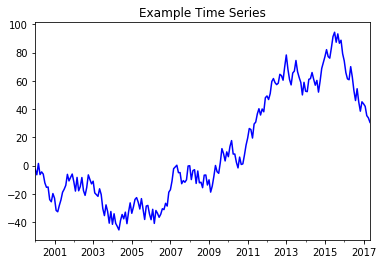

2000-01-31    -2.541790
2000-02-29    -6.442486
2000-03-31     1.563174
2000-04-30    -6.316915
2000-05-31    -4.408935
2000-06-30    -5.987130
2000-07-31   -12.173528
2000-08-31   -15.299350
2000-09-30   -15.095951
2000-10-31   -24.006255
Freq: M, dtype: float64

In [10]:
%%local
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [11]:
%%local
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[ -2.54178956]
  [ -6.44248633]
  [  1.5631742 ]
  [ -6.31691471]
  [ -4.40893548]
  [ -5.98713045]
  [-12.17352834]
  [-15.29935009]
  [-15.09595068]
  [-24.00625545]
  [-25.54237781]
  [-19.73453089]
  [-22.98559617]
  [-31.67412789]
  [-32.62897895]
  [-28.09179403]
  [-24.19821143]
  [-18.81433451]
  [-16.6930373 ]
  [-13.91257626]]

 [[ -6.14821185]
  [-10.794113  ]
  [ -8.26785872]
  [ -5.94372525]
  [-11.40267678]
  [-17.98864399]
  [ -8.31710572]
  [-17.76644527]
  [-14.81304515]
  [ -8.39904268]
  [-17.67032115]
  [-21.01748275]
  [-15.5044194 ]
  [ -6.5239458 ]
  [ -9.83116988]
  [-12.86931042]
  [-10.98793777]
  [-19.27446758]
  [-20.44139333]
  [-21.70760152]]]
[[[ -6.44248633]
  [  1.5631742 ]
  [ -6.31691471]
  [ -4.40893548]
  [ -5.98713045]
  [-12.17352834]
  [-15.29935009]
  [-15.09595068]
  [-24.00625545]
  [-25.54237781]
  [-19.73453089]
  [-22.98559617]
  [-31.67412789]
  [-32.62897895]
  [-28.09179403]
  [-24.19821143]
  [-18.81433451]
  [-16.69303

#### Pull out our test data

In [12]:
%%local
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ 93.23839664]
  [ 86.61420025]
  [ 88.74616706]
  [ 79.20694313]
  [ 74.12947392]
  [ 65.83034973]
  [ 61.40883037]
  [ 60.78487133]
  [ 70.05312652]
  [ 62.74377698]
  [ 53.13052076]
  [ 46.0882141 ]
  [ 54.43279617]
  [ 45.08058371]
  [ 38.54412873]
  [ 45.18613161]
  [ 43.7466584 ]
  [ 41.96454309]
  [ 35.3913509 ]
  [ 33.80996778]]]


In [13]:
%%local
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [14]:
%%local
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

(0, '\tMSE:', 352053.06)
(100, '\tMSE:', 14581.784)
(200, '\tMSE:', 8028.585)
(300, '\tMSE:', 3679.7852)
(400, '\tMSE:', 1820.7721)
(500, '\tMSE:', 1173.5277)
(600, '\tMSE:', 1078.7859)
(700, '\tMSE:', 914.3454)
(800, '\tMSE:', 982.80359)
(900, '\tMSE:', 831.36707)
[[[ 97.74221802]
  [ 85.65024567]
  [ 80.41075897]
  [ 73.30901337]
  [ 98.35876465]
  [ 55.93323517]
  [ 55.92270279]
  [ 69.85540771]
  [ 75.54729462]
  [ 65.85166931]
  [ 68.10777283]
  [ 49.13397217]
  [ 39.76128387]
  [ 28.84299469]
  [ 42.58358765]
  [ 51.84318924]
  [ 53.95585632]
  [ 41.48054123]
  [ 27.86694908]
  [ 22.4953289 ]]]


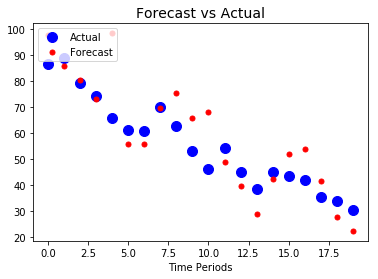

In [15]:
%%local
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

